# Time series analysis

The time series analysis is one of the statistical "powerhouse" tools as it (theorethically) allows us to predict samples from any data series avaliable to us. The uses range from stock price prediction to weather forecast.

In this exercise we will present an example of air traffic passangers, and demonstrate the steps required to create and evaluate our predictions.

## Imports
As usual we begin by loading our libraries

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf  
import warnings
warnings.filterwarnings('ignore')

## Loading data
In most of cases the data is stored in the form of a csv file, which is then parsed and stored into an appropriate container - a pandas dataframe in our case.
We can also plot the relevant data to get the idea what we will be working with.

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


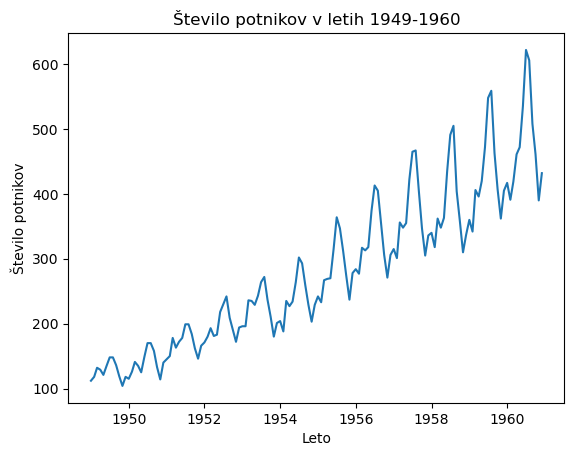

In [3]:
data = pd.read_csv('AirPassengers.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=True, index_col='Month',date_parser=dateparse)
print (data.head())

data.index
ts = data['#Passengers']
ts.head(10)
plt.figure()
plt.plot(ts)
plt.xlabel("Leto")
plt.ylabel("Število potnikov")
plt.title("Število potnikov v letih 1949-1960")
plt.savefig("vaja4_1.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Testing the data
The principal requirement of the TS analysis is the stationarity of the input data - i.e. it must either grow / decline at a constant rate or follow a repeating pattern. 

One of the test that we can do to see whether or not the series is stationary is the Dickey-Fuller test implemented in the statsmodels library.

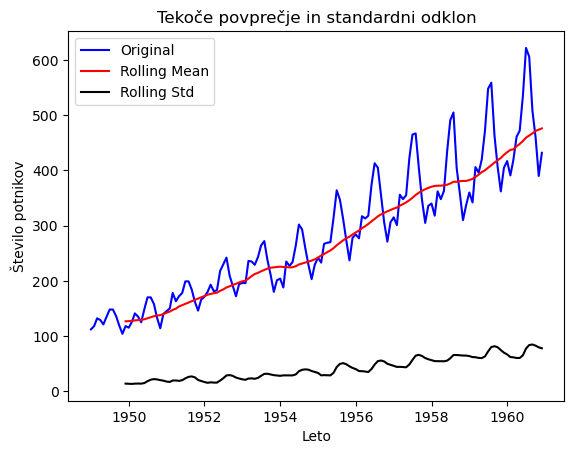

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [4]:
def test_stationarity(timeseries,figName):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Tekoče povprečje in standardni odklon')
    plt.xlabel("Leto")
    plt.ylabel("Število potnikov")
    plt.savefig(figName, format="pdf", bbox_inches="tight")
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(ts,"vaja4_2.pdf")

The imporant aspect of the tests printout is the test statistic and the critical values. The simple version is - if the Test Statistic is smaller than the 1/5/10% value we can say that 99/95/90% of the data in the series is stationary and thus appropriate for TS.

Our data is therefore not prepared for this.

## Trend elimination
The task is therefore to se if we can transfrom this series in a way that would allow us to use in TS. The tool avaliable to use are:
* Use a function that filters rapid changes (log, square root)
* Aggregation - use the moving average of each period
* Smoothing - use the moving average
* Regression model
* Derivation

### General tools
In our example we will use the follwoing:
* X = log(X) - average over last 12 months
* X = ewma(log(x)) - expotential weighted moving average

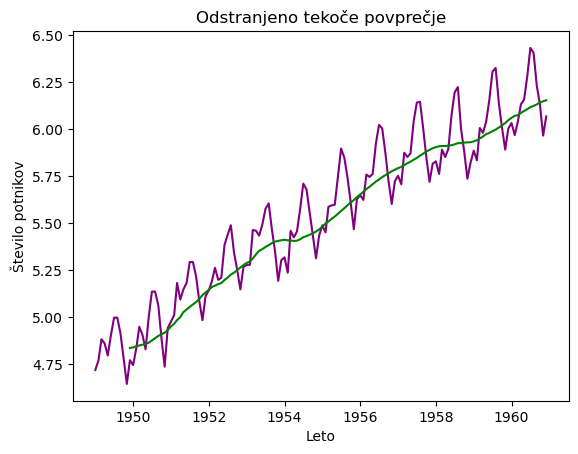

In [114]:
ts_log = np.log(ts)
moving_avg = ts_log.rolling(12).mean()

plt.figure()
plt.plot(ts_log, label="Log", color="purple")
plt.plot(moving_avg, color='green', label="Moving average")
plt.xlabel("Leto")
plt.ylabel("Število potnikov")
plt.title("Odstranjeno tekoče povprečje")
plt.savefig("vaja4_3.pdf", format="pdf", bbox_inches="tight")
plt.show()

Testing moving average difference


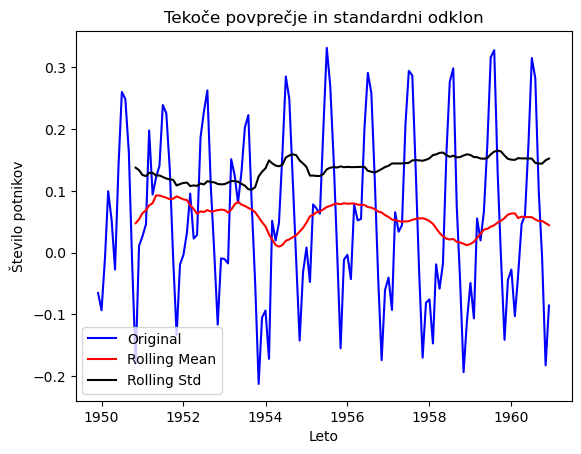

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [117]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)
#print(ts_log_moving_avg_diff.head(12))

ts_log_moving_avg_diff.dropna(inplace=True)
print( "Testing moving average difference")
test_stationarity(ts_log_moving_avg_diff,"vaja4_4.pdf")

Removing the moving average, seems to have improved our series since the test statistic now shows that 95% of our data should now be stationary. The problem with this approach however is that we require prior knowledge (that we use a period of 12 months). In order to avoid this and to also introduce additional options such as giving more importance to more recent numbers, we use the expotentially weighted moving average.

Testing weighted average


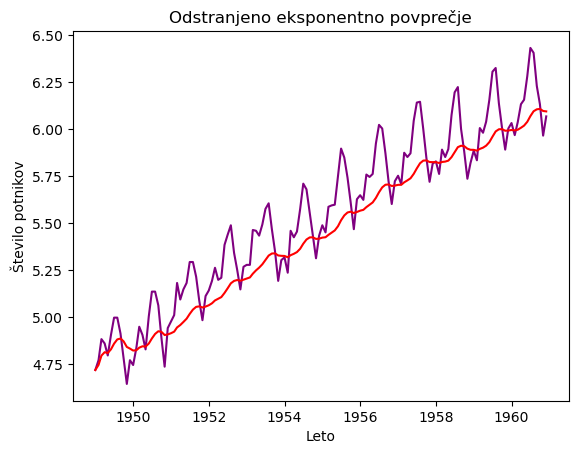

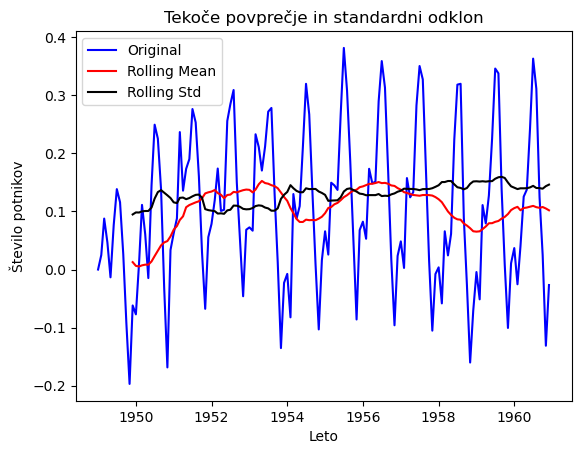

Results of Dickey-Fuller Test:
Test Statistic                  -3.566092
p-value                          0.006443
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [119]:
expwighted_avg = ts_log.ewm(12).mean()
plt.figure()
plt.plot(ts_log, label="Log", color="purple")
plt.plot(expwighted_avg, color='red', label="weighted avergae")
plt.xlabel("Leto")
plt.ylabel("Število potnikov")  
plt.title("Odstranjeno eksponentno povprečje")
plt.savefig("vaja4_6.pdf", format="pdf", bbox_inches="tight")

ts_log_ewma_diff = ts_log - expwighted_avg
print ("Testing weighted average")
test_stationarity(ts_log_ewma_diff,"vaja4_5.pdf")



The result is even better than before since we now achived 99%.

We can however further improve our result using an additional tool.
### Sesionality
If we suspect that our data includes seasonal patterns we can use additional tools in our arsenal. The first is *differencing* which tries to remove seasonality and trends at the same time by substracting a shifted version of data from the original.
* X = log(X(t)) - log(X(t-shift))

testing log - shifted log


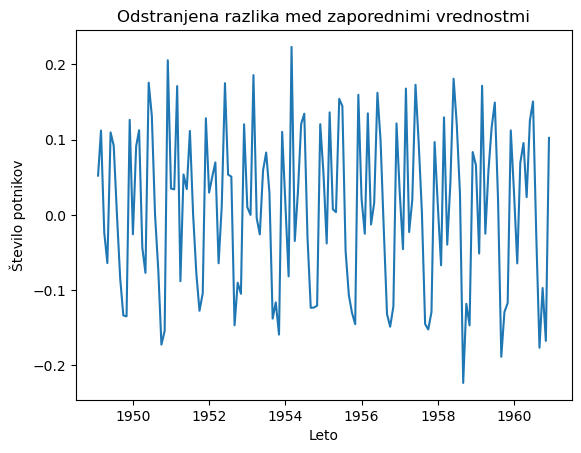

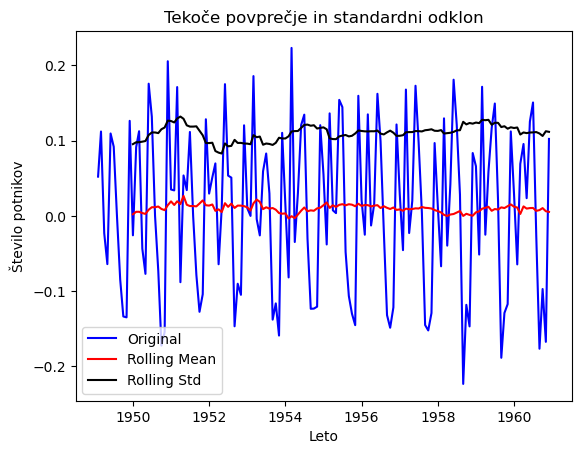

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [120]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure()
plt.plot(ts_log_diff)
plt.xlabel("Leto")
plt.ylabel("Število potnikov")
plt.title("Odstranjena razlika med zaporednimi vrednostmi")
plt.savefig("vaja4_8.pdf", format="pdf", bbox_inches="tight")

ts_log_diff.dropna(inplace=True)
print ("testing log - shifted log")
test_stationarity(ts_log_diff,"vaja4_7.pdf")

We can see that this did not work so well since we now only got a 90% statioanry dataset. This means that there is some seasonality in it, but in a more complex form. We therefore use a more poverfull tool - *Seasonal decomposition*, which splits the data into three series:
* trend - the data that we simply add to predictions
* seasonal data - the seasonal changes
* residual - the data we will be trying to predict

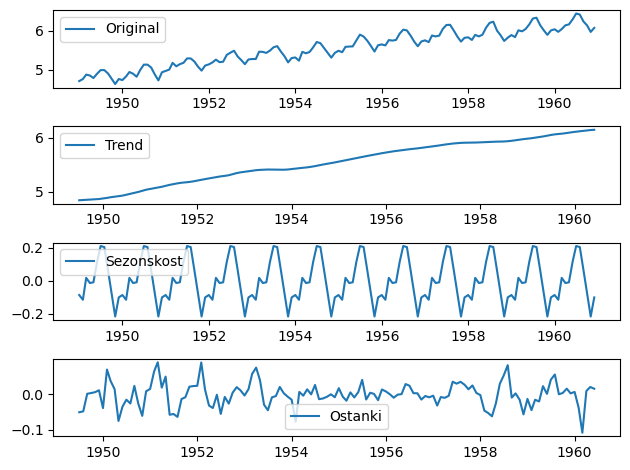

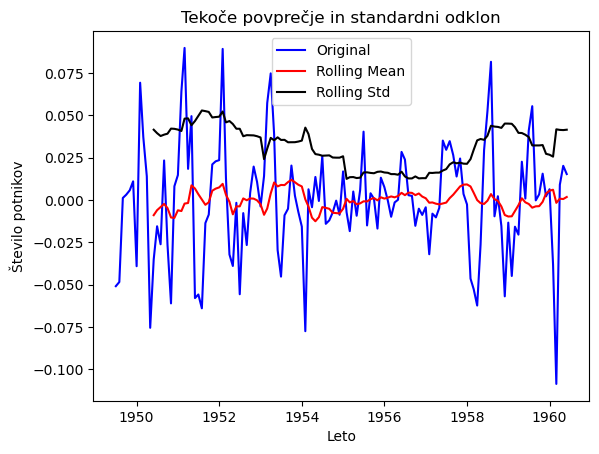

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [121]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure()
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Sezonskost')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Ostanki')
plt.savefig("vaja4_10.pdf", format="pdf", bbox_inches="tight")
plt.legend(loc='best')

plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose,"vaja4_9.pdf")

This is our best result so far as we are way below the 1% value and now have our best version of the data to work with.

Our next task is creating the model and using it for predictions.
## Building a TS model
For this stage we will focus on the differentiated version of our data, even if the seasonal version proved to be the best.

The parameters of the model consist of three numbers:
* p - the number of samples to use in our model
* q - the number of errors (correlation) to be used in our model
* d - level of derivative (first-order etc.)

We have allready deterimned the d parameter by using a differentiated dataset - each level of diff. euqals to +1 to the vallue of the *d* parameter. We can therefore either use the original data and set *d* to 1 or use the ``ts_log_diff`` and set it to 0.

The other two parameters must be determined from the Autocorrelation function (ACF) and the Partial Autocorrelation function (PACF) show here:

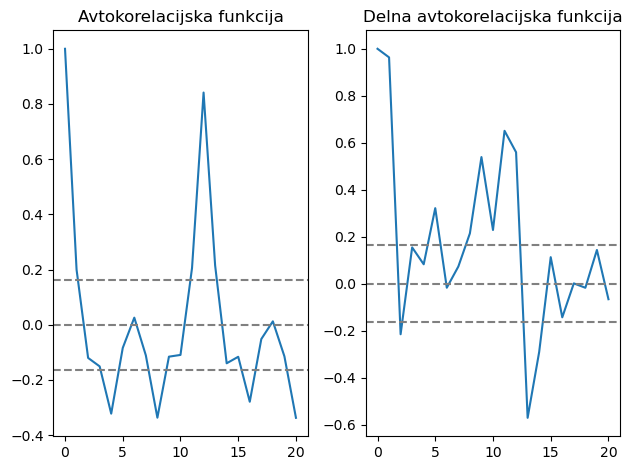

In [124]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log, nlags=20, method='ols')

plt.figure()
#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Avtokorelacijska funkcija')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Delna avtokorelacijska funkcija')
plt.tight_layout()
plt.savefig("vaja4_11.pdf", format="pdf", bbox_inches="tight")
plt.show()

To set the *p* and *q* values we must find the spot (as an integer) in which the ACF (for *q*) and PACF (for *p*) falls bellow the confidence interval for the first time (i.e. bellow the upper dotted line).

We can see that in our example this means 2 for both funtions.

Our ideal model would therefore be *p=2,d=0,q=2*.
We can now start creating our models and show some examples. Each case will also feature the Residual sum of squares as it's score - the lower the better.

## AR model
This model ignores any errors and has therefore it's *q* set to 0.

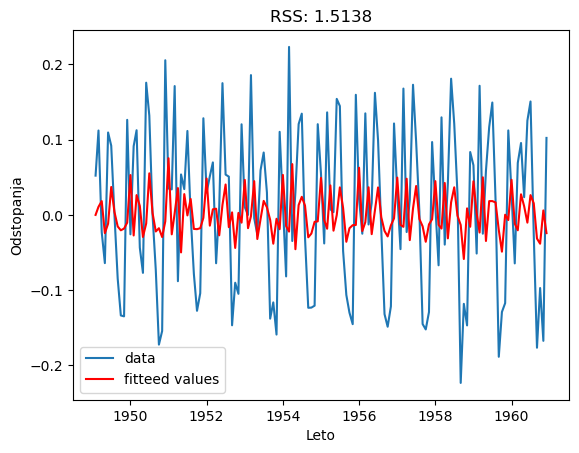

In [127]:
#AR model:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(ts_log, order=(2, 1, 0),simple_differencing=True)  
results_AR = model.fit() 
plt.figure()
plt.plot(ts_log_diff, label="data")
plt.plot(results_AR.fittedvalues, color='red', label="fitteed values")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.legend(loc='best')
plt.xlabel("Leto")
plt.ylabel("Odstopanja")
plt.savefig("vaja4_12.pdf", format="pdf", bbox_inches="tight")
plt.show()

The next is the opposite model which focuses only on the error - the MA model.

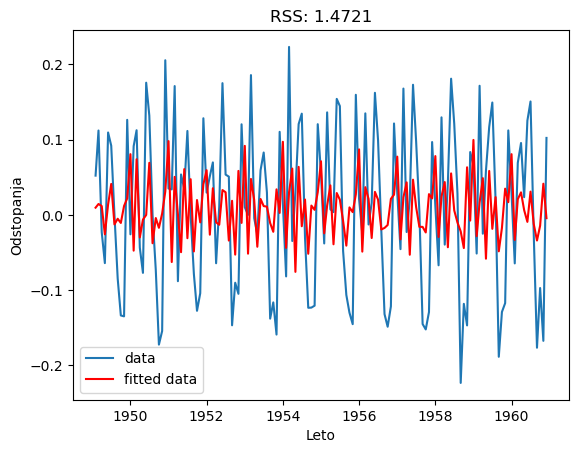

In [128]:
#MA model:
model = ARIMA(ts_log_diff, order=(0, 0, 2))  
results_MA = model.fit()  
plt.figure()
plt.plot(ts_log_diff, label="data")
plt.plot(results_MA.fittedvalues, color='red', label="fitted data")
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.legend(loc='best')
plt.xlabel("Leto")
plt.ylabel("Odstopanja")
plt.savefig("vaja4_13.pdf", format="pdf", bbox_inches="tight")
plt.show()

And last the model that we defined as "best" - The ARIMA model.

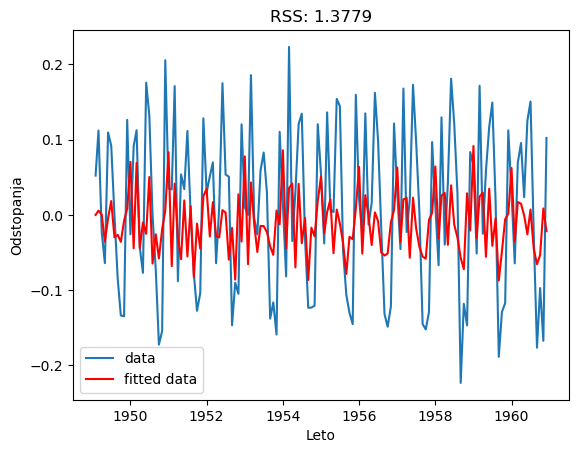

In [129]:
#ARIMA model:
#model = ARIMA(ts_log, order=(2, 1, 2)) 
model = SARIMAX(ts_log, order=(2, 1, 2),simple_differencing=True) 
results_ARIMA = model.fit()
plt.figure()
plt.plot(ts_log_diff, label="data")
plt.plot(results_ARIMA.fittedvalues, color='red', label="fitted data")
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.legend(loc='best')
plt.xlabel("Leto")
plt.ylabel("Odstopanja")
plt.savefig("vaja4_14.pdf", format="pdf", bbox_inches="tight")
plt.show()

We can now calculate the difference between the real values and the predicted values using the head() command.

In [75]:
print (results_ARIMA.fittedvalues.head())

Month
1949-02-01    0.000000
1949-03-01    0.005701
1949-04-01    0.000414
1949-05-01   -0.035392
1949-06-01   -0.004388
dtype: float64


And last but not least plot the predicted vs. true.

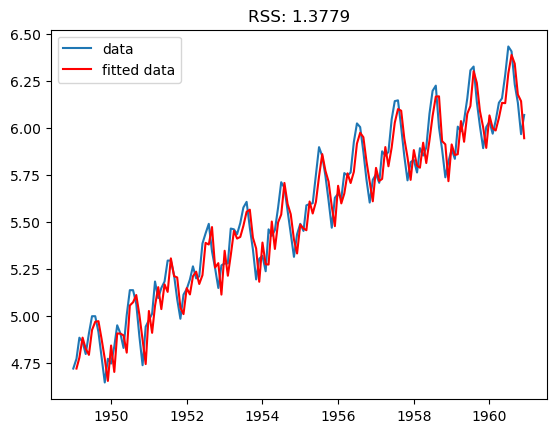

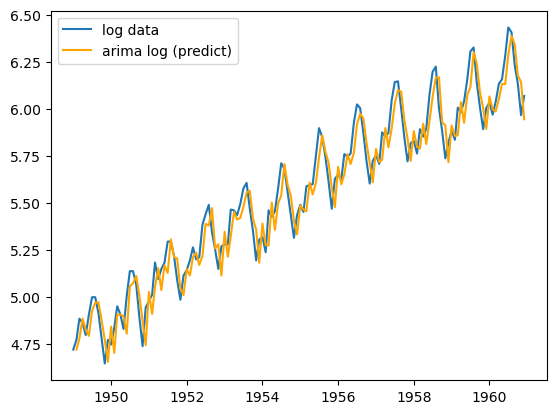

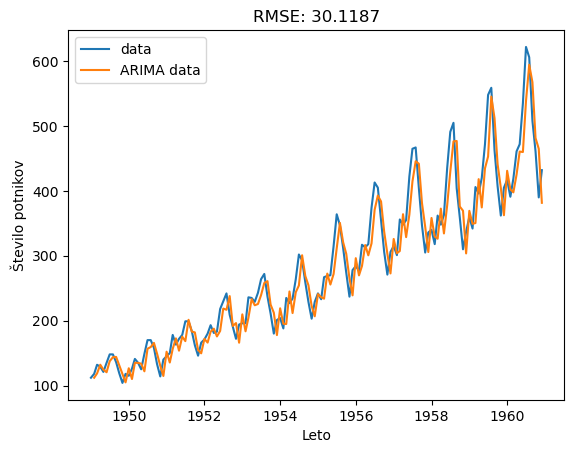

In [130]:
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit()

# Napovedi na logaritemski lestvici
predictions_ARIMA_log = results_ARIMA.predict(start=1, end=len(ts_log)-1, typ='levels')
predictions_ARIMA_log.index = ts_log.index[1:len(predictions_ARIMA_log)+1]

predicted_log = results_ARIMA.predict(start=1, end=len(ts_log)-1, typ='levels')
predicted_log.index = ts_log.index[1:len(predicted_log)+1]

plt.figure()
plt.plot(ts_log, label="data")
plt.plot(predicted_log, color='red', label="fitted data")
plt.title('RSS: %.4f' % np.sum((predicted_log - ts_log[1:])**2))
plt.legend(loc='best')
plt.show()


# Prikaz log napovedi
plt.figure()
plt.plot(ts_log, label="log data")
plt.plot(predictions_ARIMA_log, label="arima log (predict)", color='orange')
plt.legend(loc='best')
plt.show()

# Pretvorba nazaj v originalno mersko enoto
predictions_ARIMA = np.exp(predictions_ARIMA_log)

# Prikaz napovedi v originalnih enotah
plt.figure()
plt.plot(ts, label="data")
plt.plot(predictions_ARIMA, label="ARIMA data")
plt.title('RMSE: %.4f' % np.sqrt(np.mean((predictions_ARIMA - ts[1:len(predictions_ARIMA)+1]) ** 2)))
plt.legend(loc='best')
plt.xlabel("Leto")
plt.ylabel("Število potnikov") 
plt.savefig("vaja4_15.pdf", format="pdf", bbox_inches="tight")
plt.show()

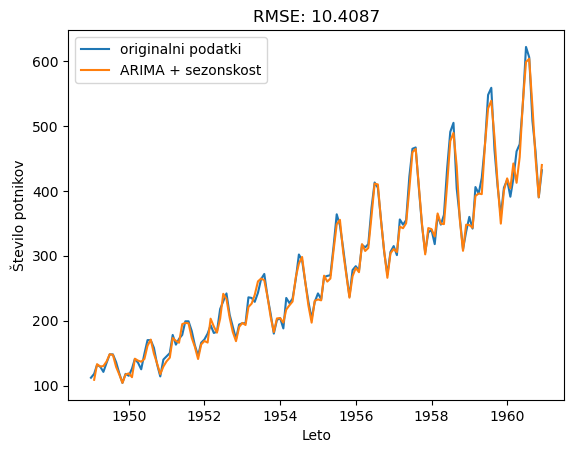

In [131]:
decomposition = seasonal_decompose(ts_log, model='additive')
seasonal = decomposition.seasonal
in_data = ts_log - seasonal

# Gradnja modela na sezonsko očiščeni seriji
model_in = ARIMA(in_data.dropna(), order=(2, 1, 2))
results_in = model_in.fit()

# Napovedi (log-lestvica)
predictions_log = results_in.predict(start=1, end=len(in_data.dropna())-1, typ='levels')
predictions_log.index = in_data.dropna().index[1:len(predictions_log)+1]

# Dodaj nazaj sezonskost
seasonal_trimmed = seasonal[predictions_log.index]
predictions_log_seasonal = predictions_log + seasonal_trimmed

# Pretvorba nazaj v originalno skalo
predictions_final = np.exp(predictions_log_seasonal)

# Vizualizacija
plt.figure()
plt.plot(ts, label="originalni podatki")
plt.plot(predictions_final, label="ARIMA + sezonskost")
plt.title('RMSE: %.4f' % np.sqrt(np.mean((predictions_final - ts[1:len(predictions_final)+1]) ** 2)))
plt.legend(loc='best')
plt.xlabel("Leto")
plt.ylabel("Število potnikov")
plt.savefig("vaja4_16.pdf", format="pdf", bbox_inches="tight")
plt.show()

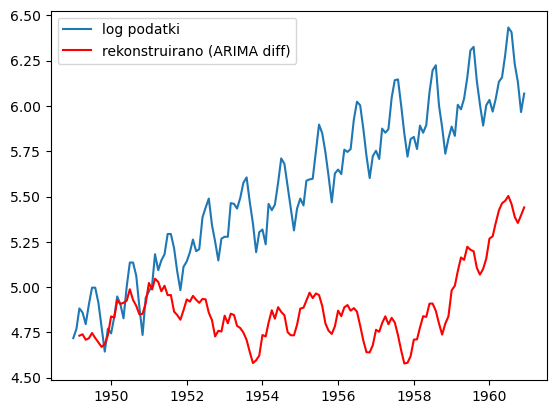

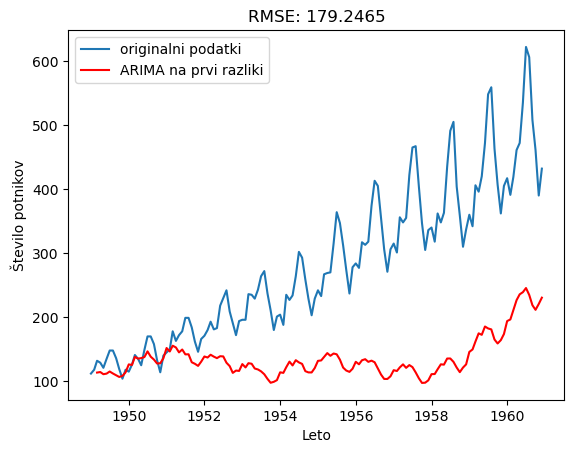

In [132]:
ts_log_diff = ts_log.diff().dropna()

# ARIMA model na diferencirani seriji
model_diff = ARIMA(ts_log_diff, order=(2, 0, 2))
results_diff = model_diff.fit()

# Napoved diferenciranih vrednosti
predicted_diff = results_diff.predict(start=1, end=len(ts_log_diff)-1, typ='levels')
predicted_diff.index = ts_log_diff.index[1:len(predicted_diff)+1]

# Rekonstrukcija log-serije iz napovedane razlike
reconstructed_log = ts_log.iloc[0] + predicted_diff.cumsum()

# Izris rekonstruiranega signala (log skala)
plt.figure()
plt.plot(ts_log, label="log podatki")
plt.plot(reconstructed_log, color='red', label="rekonstruirano (ARIMA diff)")
plt.legend(loc='best')
plt.show()

# Pretvorba v originalno skalo
predicted = np.exp(reconstructed_log)

# Izris v originalni merski enoti
plt.figure()
plt.plot(ts, label="originalni podatki")
plt.plot(predicted, color='red', label="ARIMA na prvi razliki")
plt.title('RMSE: %.4f' % np.sqrt(np.mean((predicted - ts[1:len(predicted)+1]) ** 2)))
plt.legend(loc='best')
plt.xlabel("Leto")
plt.ylabel("Število potnikov")
plt.savefig("vaja4_17.pdf", format="pdf", bbox_inches="tight")
plt.show()

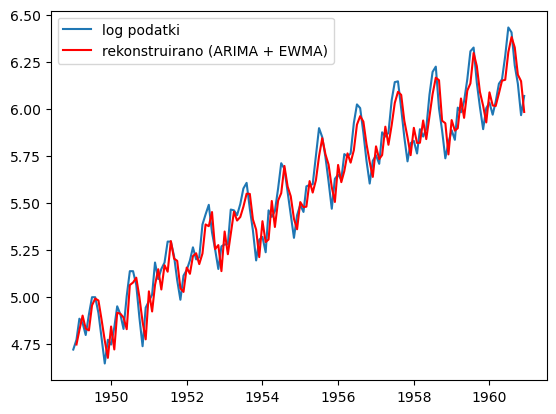

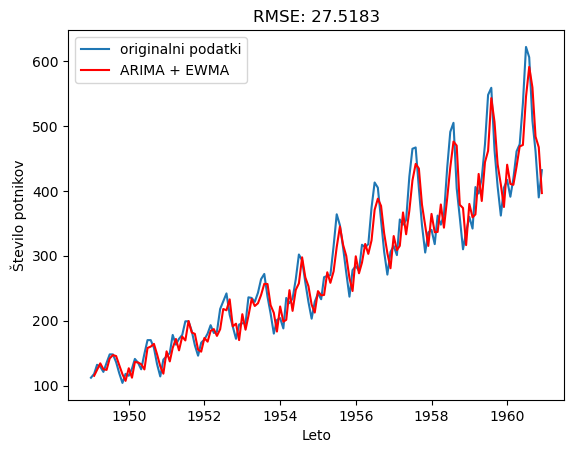

In [133]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

# Preostanek (log serija - EMA)
in_data = ts_log - expwighted_avg

# ARIMA model na preostanku
model_ewma = ARIMA(in_data.dropna(), order=(2, 1, 2))
results_ewma = model_ewma.fit()

# Napoved (log lestvica, brez EMA)
predicted_log = results_ewma.predict(start=1, end=len(in_data.dropna())-1, typ='levels')
predicted_log.index = in_data.dropna().index[1:len(predicted_log)+1]

# Rekonstrukcija: dodaj nazaj EMA
ema_part = expwighted_avg[predicted_log.index]
predicted_log_reconstructed = predicted_log + ema_part

# Izris rekonstruiranega log-signala
plt.figure()
plt.plot(ts_log, label="log podatki")
plt.plot(predicted_log_reconstructed, color='red', label="rekonstruirano (ARIMA + EWMA)")
plt.legend(loc='best')
plt.show()

# Pretvorba v originalno skalo
predicted = np.exp(predicted_log_reconstructed)

# Izris v originalni merski enoti
plt.figure()
plt.plot(ts, label="originalni podatki")
plt.plot(predicted, color='red', label="ARIMA + EWMA")
#plt.title('RSS: %.4f' % np.sum((predicted - ts[1:len(predicted)+1])**2))
plt.title('RMSE: %.4f' % np.sqrt(np.mean((predicted - ts[1:len(predicted)+1]) ** 2)))
plt.legend(loc='best')
plt.xlabel("Leto")
plt.ylabel("Število potnikov")
plt.savefig("vaja4_18.pdf", format="pdf", bbox_inches="tight")
plt.show()